In [111]:
'''
NOTES:

Using the complimentary filter for orientation estimation automatically
aligns the world coordinate system with the true world coordinate
system. 

Using an alpha of 0.98 converges the world to truth in 2 seconds.
Alpha of 0.96 brings convergence in about 0.8 seconds.


PowerSense accel data is too filtered to capture motion accelerations. 
Using pre-gravity corrected user acc data works well to estimate trajectory.
Issue now is correcting for position drift into the floot
'''

'\nNOTES:\n\nUsing the complimentary filter for orientation estimation automatically\naligns the world coordinate system with the true world coordinate\nsystem. \n\nUsing an alpha of 0.98 converges the world to truth in 2 seconds.\nAlpha of 0.96 brings convergence in about 0.8 seconds.\n\n\nPowerSense accel data is too filtered to capture motion accelerations. \nUsing pre-gravity corrected user acc data works well to estimate trajectory.\nIssue now is correcting for position drift into the floot\n'

In [112]:
# import statements
import os
import pandas
import glob
import numpy as np
from matplotlib import pyplot as plt
import quaternion
import scipy.integrate
import scipy.signal

%matplotlib notebook

In [113]:
def load_iphone_data(data_file):
    """
    Load data csv into memory using Pandas
    """

    # Load dataframe
    data_df = pandas.read_csv(data_file)

    # Remove rows in csv where there is null data
    data_df = data_df[pandas.notnull(data_df['rotation_rate_x(radians/s)'])]

    # Load timestamps, start time at 0
    data_t = data_df['timestamp(unix)'].values - data_df['timestamp(unix)'].values[0]

    # Load gyro data into num samples x 3 matrix
    data_gyro_x = data_df['rotation_rate_x(radians/s)'].values
    data_gyro_y = data_df['rotation_rate_y(radians/s)'].values
    data_gyro_z = data_df['rotation_rate_z(radians/s)'].values
    data_gyro = np.stack([data_gyro_x, data_gyro_y, data_gyro_z],axis=1)

    # Load accel data into num samples x 3 matrix
    data_accel_x = data_df['gravity_x(G)'].values
    data_accel_y = data_df['gravity_y(G)'].values
    data_accel_z = data_df['gravity_z(G)'].values
    data_accel = np.stack([data_accel_x, data_accel_y, data_accel_z],axis=1)
    
    # Load user acceleration data into num samples x 3 matrix
    # Note: for some reason the user motion is backwards
    user_motion = -np.stack([data_df['user_acc_x(G)'].values,
                            data_df['user_acc_y(G)'].values,
                            data_df['user_acc_z(G)'].values],axis=1)
    
    return (data_t,data_gyro,data_accel,user_motion)

In [114]:
# Use samples 0 to 500 as init range
# NOTE: This uses a two vector method to build the initial quaternion
# so the forward vector is always in the direction from which the
# accel vector points away from the local up vector, this definitely causes
# funky coordinate system orientations
#### TODO DONT USE THIS FUNCTION, just treat la0 as gG

def get_initial_orientation(accel_data):
    """
    Computes the initial sensor orientation.
    
    Computes the initial quaternion orientation of the sensor
    in the global frame based off accelerometer data from an 
    initial resting period.
    
    Parameters
    ----------
    accel_data : m x 3 nd array
        Acceleration samples

    Returns
    -------
    quaternion
        Initial orientation quaternion
    """
    
    # TODO: base initializatio period off of timeseries data
    initialization_timespan = range(500)

    # local acceleration nought = 
    la0 = np.mean(accel_data[initialization_timespan],axis=0)

    # build direction vector from avg acceleration
    # apply negative sign to reference the opposite of gravity
    D = -la0/np.linalg.norm(la0)

    # build reference up vector
    local_up_y = np.array([0,1,0])

    # build x vector
    x = np.cross(D,local_up_y)

    # build x vector
    z = np.cross(x,D)

    rot_mat = np.stack([x,D,z],axis=0)

    q0 = quaternion.from_rotation_matrix(rot_mat)

    la0_quat = np.quaternion(0, *la0)
#     DEBUG PRINTING
    print('avg initial local accel lg0 = {}'.format(la0))
    print('initial quaternion orientation q0 = {}'.format(q0))
    print('initial accel in global frame gG = {}'.format(q0*la0_quat*q0.conjugate()))
    
    return q0

### Compute gravity estimation from a subset of the acceleration data
def get_gravity_est(initialization_timespan, accel_data):
    """
    Estimates gravity vector from subset of accelerometer data.
    
    Parameters
    ----------
    initialization_timespan : range
        Range of data to use to estimate initial gravity 
    accel_data : m x 3 nd array
        Acceleration data

    Returns
    -------
    3-vector ndarray
        Gravity estimation
    """
    return np.mean(accel_data[initialization_timespan],axis=0)

In [115]:
# Reference: Lecture 10 EE267
def q_integrator(w_sample,DT):
    """
    Computes the quaternion delta_q for which
    q(t+1) = q(t)*delta_q
    
    Parameters
    ----------
    w_sample : 3-vector
        gyro data sample
    DT : float
        time delta, 0.01s for iphone data

    Returns
    -------
    quaternion
        integrator quaternion to update orientation vector
    """
    omega = np.linalg.norm(w_sample)
    d_omega = omega*DT
    w_normalized = w_sample / omega
    
    delta_q = angle_axis_quat(d_omega,w_normalized)
    return delta_q

def angle_axis_quat(theta,normalized_axis):
    """
    Computes a quaternion in angle-axis form
    
    Parameters
    ----------
    theta : float
        Amount to rotate around axis
    normalized_axis : 3-vector ndarray
        Normalized axis around which to rotate

    Returns
    -------
    quaternion
        angle-axis rotation vector
    """
    qw = np.cos(theta/2)
    qxyz = normalized_axis*np.sin(theta/2)
    return np.quaternion(qw,*qxyz)

# v is normalized acceleration direction
# NOTE: v must be in format such that vy is negative g (-1G)
# NOTE: gyro data from iphone may already be corrected by accelerometer
def accel_correcting_quat(alpha,local_accel,orientation):
    """
    Computes the quaternion to correct slightly for gyro drift
    
    Parameters
    ----------
    alpha : float
        Complimentary filter parameter, <=1, lower means more weight
        to accelerometer data
    local_accel : 3-vector
        Local acceleration sample data
    orientation : quaternion
        Local-to-global orientation quaternion
        
    Returns
    -------
    quaternion
        Quaternion by which orientation is multiplied to correct orientation
    """
    
    global_accel = orientation* \
                   np.quaternion(0,*local_accel)* \
                   orientation.conjugate()
    global_accel = global_accel.vec
    
    v = global_accel / np.linalg.norm(global_accel)
    
    reference_grav = np.array([0,-1,0])
    cosphi = np.dot(v,reference_grav)
    phi = np.arccos(cosphi)
    
    # rotor for correction quaternion
    n = np.cross(v,reference_grav)
    
    # normalize the rotor vector
    n = n/np.linalg.norm(n)
    
    return angle_axis_quat((1-alpha)*phi,n)

def get_orientation_timeseries(v,a,q0=np.quaternion(1,0,0,0),alpha=0.98,DT=0.01):
    """
    Combines gyro and accel data using complimentary filter to estimate
    the pose at every time sample.
    
    Parameters
    ----------
    v : m x 3 ndarray
        gyro data
    a : m x 3 ndarray
        accel data
    q0 : quaternion
        Initial orientation
    alpha : float
        Weight of gyro data to use for complimentary filter. 0.98 works well
    DT : float
        Time step size
        
    Returns
    -------
    list of quaternions
        Quaternion orientation for each time sample
    """
    assert v.shape == a.shape

    quat_timeseries = [q0]
    quat_unfiltered = [q0]

    ### Iterate through each gyro sensor datum, and rotate quaternion orientation 
    # by the angular velocity. Then correct for accelerometer ###

    i=0
    while i < v.shape[0]:
        w_sample = v[i]
        a_sample = a[i]
        q_now = quat_timeseries[-1]

        # set body orientation (t+1)
        q_next_gyro = q_now * q_integrator(w_sample, DT)
        quat_unfiltered.append(q_next_gyro)

        # correct quaternion based on acceleration    
        correction_q = accel_correcting_quat(alpha,a_sample,q_now)
        q_next = correction_q * q_next_gyro

        quat_timeseries.append(q_next)

        i += 1

    return quat_timeseries

def local_vec_to_global(v, q):
    """
    Converts a local quaternion to global quaternion using the q orientation 
    """
    return (q*np.quaternion(0,*v)*q.conjugate()).vec

def v_local_vec_to_global(v_ts, q_ts):
    """
    Converts a list of local quaternions to global the q orientation timeseries
    """
    return np.array([local_vec_to_global(v,q) for (v,q) in zip(v_ts,q_ts)])

def find_stance(world_acc,acc_min_energy = 0.2):
    """
    Find stance windows using Acceleration Magnitude Detector
    
    Convert user acceleration data into global acceleration then
    use MAG detector to find stance
    
    Parameters
    ----------
    world_acc : m x 3 ndarray
        world acceleration of sensor that has gravity accounted for
        
    Returns
    -------
    ndarray 
        1 if stance, 0 if not stance
    """

    # CONFIG
    # zupt alg uses 0.025m2/s4 for min energy!! HOWWW
    G = 9.81
    
    # ZUPT acceleration magnitude detection for stance
    window_size = 0.1/DT # 10 samples when sampling at 100hz
    window_radius = int(window_size/2)
    
    # Acc energy at every sliding window
    energies = np.zeros((window_radius,1))

    # Find stance windows
    for i in range(window_radius, world_acc.shape[0] - window_radius):
        window_range = range(i - window_radius,i + window_radius)

        # vector of norm2 of accelerations
        window_energy_vec = np.linalg.norm(world_acc[window_range]*G,
                                           axis=1) **2
        # mean square acceleration m2/s4 across the window
        window_energy_mean = np.mean(window_energy_vec)

        energies = np.append(energies,window_energy_mean)
    
    energies = np.append(energies,np.zeros((window_radius,)))
    # Detect when avg acc energy is less than 0.1 m2 / s4
    stance = (energies < acc_min_energy)
    
    return stance
    
### Integrate using trap rule and zero at each ST
def integrate_vel_using_stance(world_acc,stance,dt):
    """
    Integrates world acceleration vectors to compute world sensor
    velocity and sets velocity to zero during stance periods.
    
    Parameters
    ----------
    world_acc : m x 3 ndarray
        world acceleration of sensor that has gravity accounted for
    
    stance : m x 1 ndarray
        array that is 1 during stance and 0 elsewhere
        
    Returns
    -------
    ndarray 
        cumultive integration of world acceleration
    """
    world_vel = np.zeros((world_acc.shape[0],3))
    # implicit global_vel[0] = 0 3-vec

    for i in range(0,world_vel.shape[0]-1):
        if stance[i]:
            world_vel[i+1] = 0
        else:
            world_vel[i+1] = world_vel[i] + world_acc[i]*dt
    return world_vel

def integrate_pos_using_stance(world_vel,stance,dt,vert_axis=1):
    """
    Integrates world velocity vectors to compute world sensor
    position and sets y position to zero during stance periods.
    
    Parameters
    ----------
    world_vel : m x 3 ndarray
        world velocity of sensor
    
    stance : m x 1 ndarray
        array that is 1 during stance and 0 elsewhere
        
    Returns
    -------
    ndarray 
        cumultive integration of world velocity
    """
    world_pos = np.zeros((world_vel.shape[0],3))
    # implicit global_vel[0] = 0 3-vec

    for i in range(0,world_pos.shape[0]-1):
        world_pos[i+1] = world_pos[i] + world_vel[i]*dt
        if stance[i]:
            world_pos[i+1,vert_axis] = 0
            
    return world_pos

In [116]:
def plot_direction_vector(quat_ts, quat_unfiltered=np.nan):
    """
    Plots the sensor direction vector's xy components
    [TODO PARAMS AND RETURN]
    """
    # Compute the transformations of an upwards vector
    v = np.quaternion(0,0,1,0)
    up_vectors = np.array([(q*v*q.conjugate()).vec for q in quat_timeseries])
    
    ### Plot y basis vector timeseries
    plt.figure()
    plt.plot(up_vectors[:,0:2])
    
    if ~np.any(np.isnan(quat_unfiltered)):
        up_vectors_unfiltered = np.array([(q*v*q.conjugate()).vec for q in quat_unfiltered])
    
        plt.plot(up_vectors_unfiltered[:,0:2])
        plt.legend(['x filtered','y filtered','x unfiltered','y unfiltered'])
    else:
        plt.legend(['x filtered','y filtered'])
        
    plt.show()

In [117]:
"""
List all data files so the user can 
select the appropriate one
"""
data_files = glob.glob(os.getcwd()+'/data/*.csv')
data_files

['/Users/nathan/Documents/retrotope_refactor/data/vertical rotation test.csv',
 '/Users/nathan/Documents/retrotope_refactor/data/vertical side to side test.csv',
 '/Users/nathan/Documents/retrotope_refactor/data/walktest3.csv',
 '/Users/nathan/Documents/retrotope_refactor/data/walktest1.csv']

In [118]:
"""
CONFIGURATION
"""
q0 = np.quaternion(1,0,0,0)
ALPHA = 0.98
DT = 0.01
file_number = 2

PLOT_SENSOR_DATA = True

In [119]:
"""
Load data
"""
# Select the appropriate file
data_file = data_files[file_number]

# Load data
(data_t,data_gyro,data_accel,user_acc) = load_iphone_data(data_file)

In [120]:
"""
Obtain orientation by fusing gyro and accelerometer data with a 
complimentary filter
"""

# Filtered using ALPHA as gyro data weight
quat_timeseries = get_orientation_timeseries(data_gyro,data_accel,q0,ALPHA,DT)

# Unfiltered gyro integration
quat_unfiltered = get_orientation_timeseries(data_gyro,data_accel,q0,1,DT)

In [130]:
"""

"""
## Computes global accel vectors without gravity
world_accel = v_local_vec_to_global(user_acc,quat_timeseries)

### Computes stance
# Trim accelerations to just stance period
stepping_range = range(750,1500)
world_accel = world_accel[stepping_range]

# Computes stance
stance = find_stance(world_accel,4)

# Add stance period 0.25s before calculated stance periods
for i in range(stance.shape[0]):
    if stance[i] == 1:
        stance[max(0,i-25)] = 1
        
## Convert acceleration vectors from Gs to m/s2
G = 9.81
world_accel *= G

world_vel_uncorrected = scipy.integrate.cumtrapz(world_accel,dx=DT, axis=0, initial=0)
world_vel = integrate_vel_using_stance(world_accel,stance,DT)

global_pos_posy = integrate_pos_using_stance(world_vel,stance,vert_axis=1,dt=DT)
global_pos = scipy.integrate.cumtrapz(world_vel,dx = DT,axis=0)

<IPython.core.display.Javascript object>


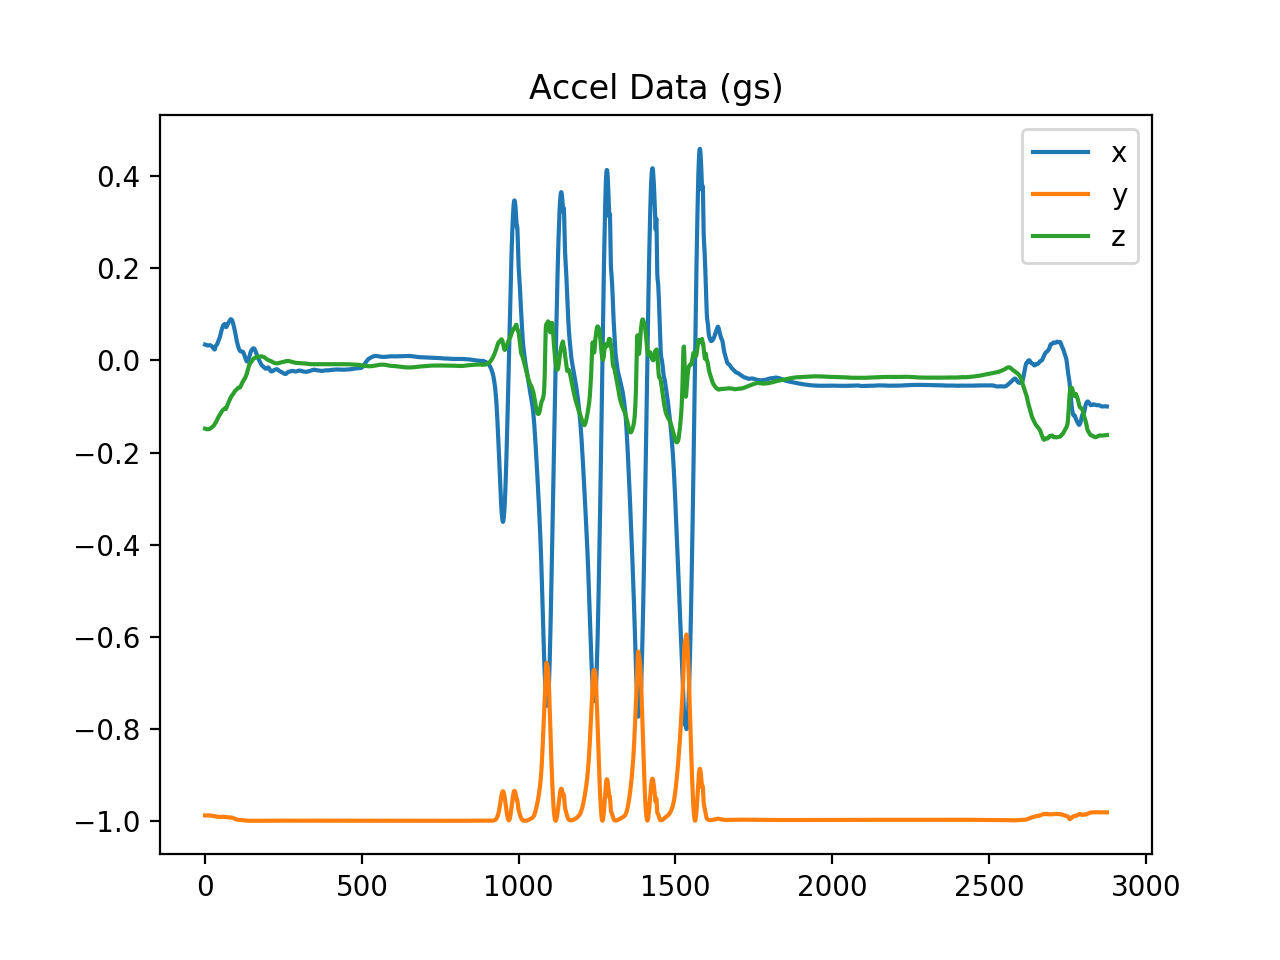

<IPython.core.display.Javascript object>


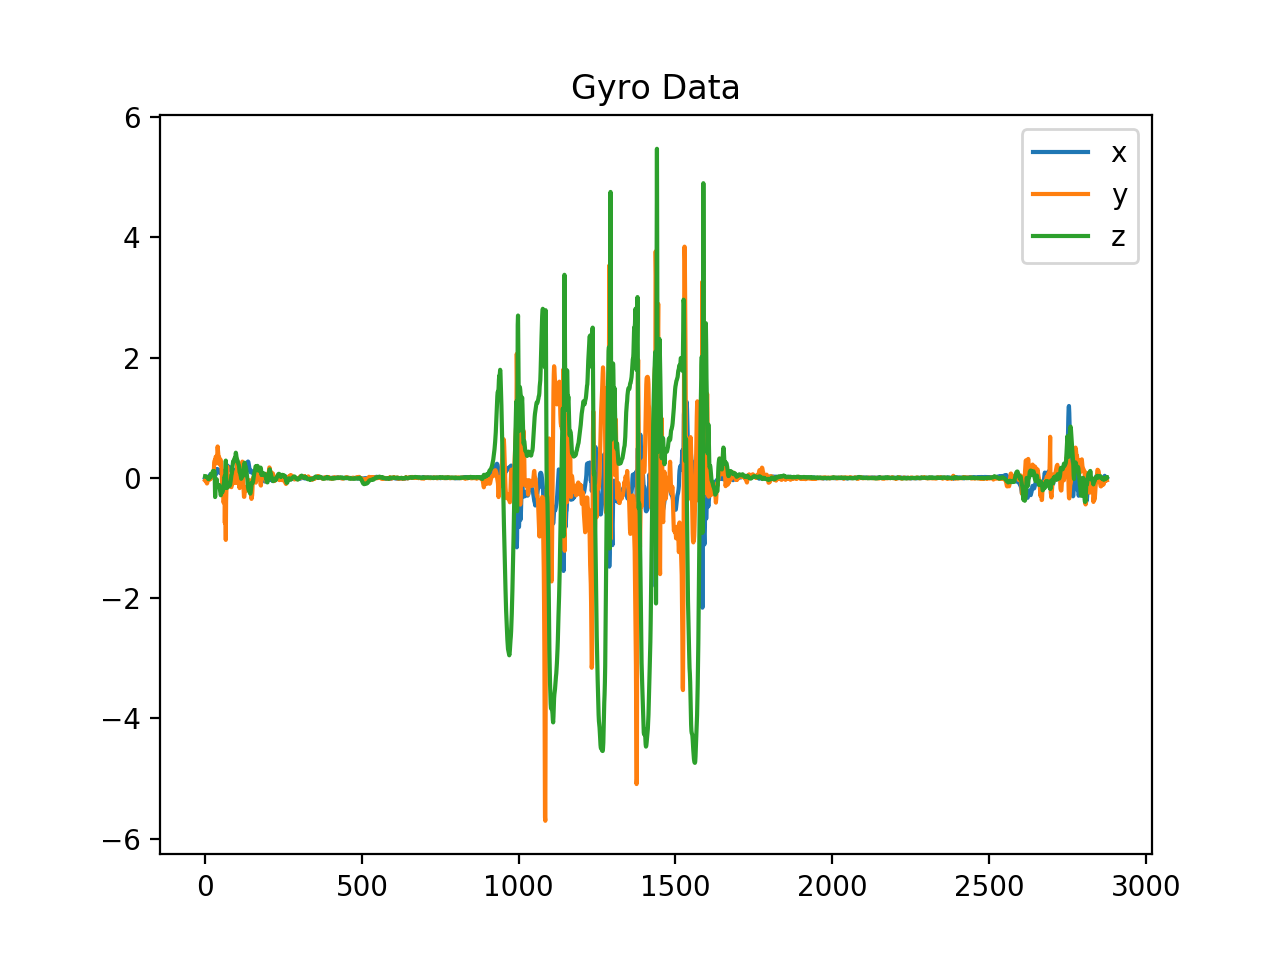

<IPython.core.display.Javascript object>


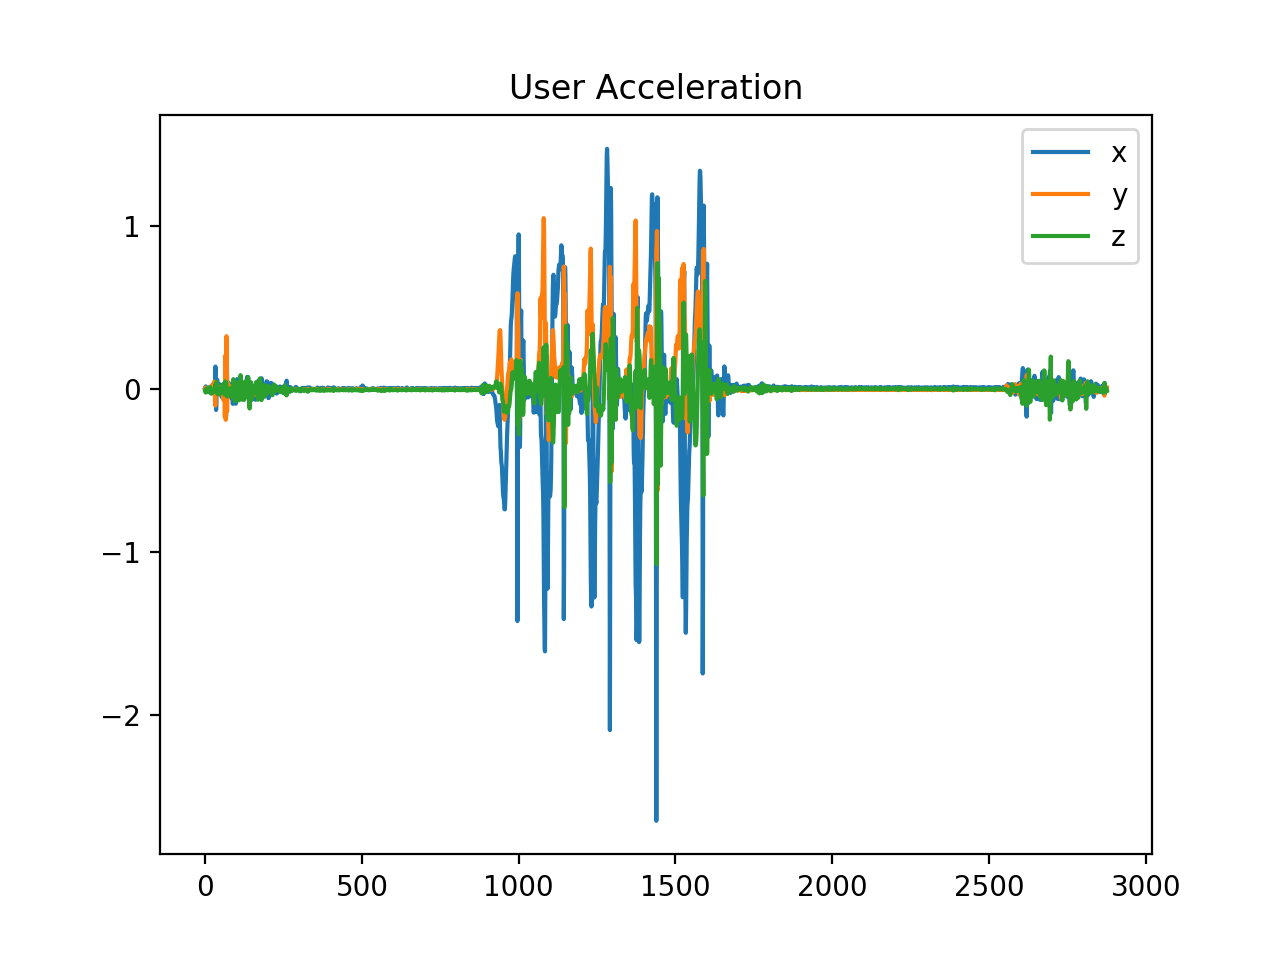

In [131]:
### Plot sensor data
if PLOT_SENSOR_DATA:
    plt.figure()
    plt.plot(data_accel)
    plt.title('Accel Data (gs)')
    plt.legend(['x','y','z'])

    plt.figure()
    plt.plot(data_gyro)
    plt.title("Gyro Data")
    plt.legend(['x','y','z'])
    
    plt.figure()
    plt.plot(user_acc)
    plt.title("User Acceleration")
    plt.legend(['x','y','z'])
    plt.show()

<IPython.core.display.Javascript object>


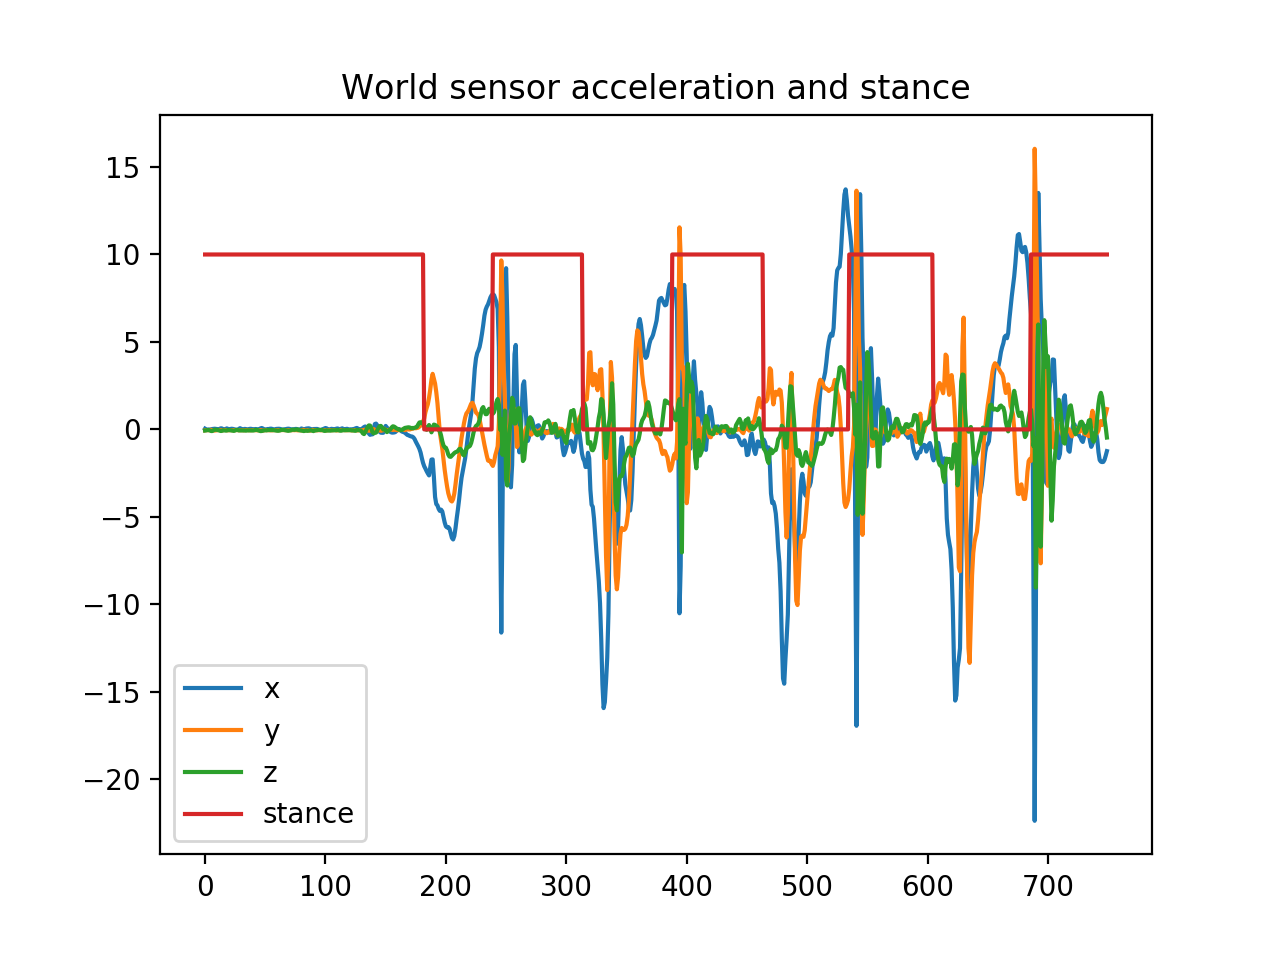

In [132]:
plt.figure()
plt.plot(world_accel)
plt.plot(stance*10)
plt.title('World sensor acceleration and stance')
plt.legend(['x','y','z','stance'])
plt.show()

<IPython.core.display.Javascript object>


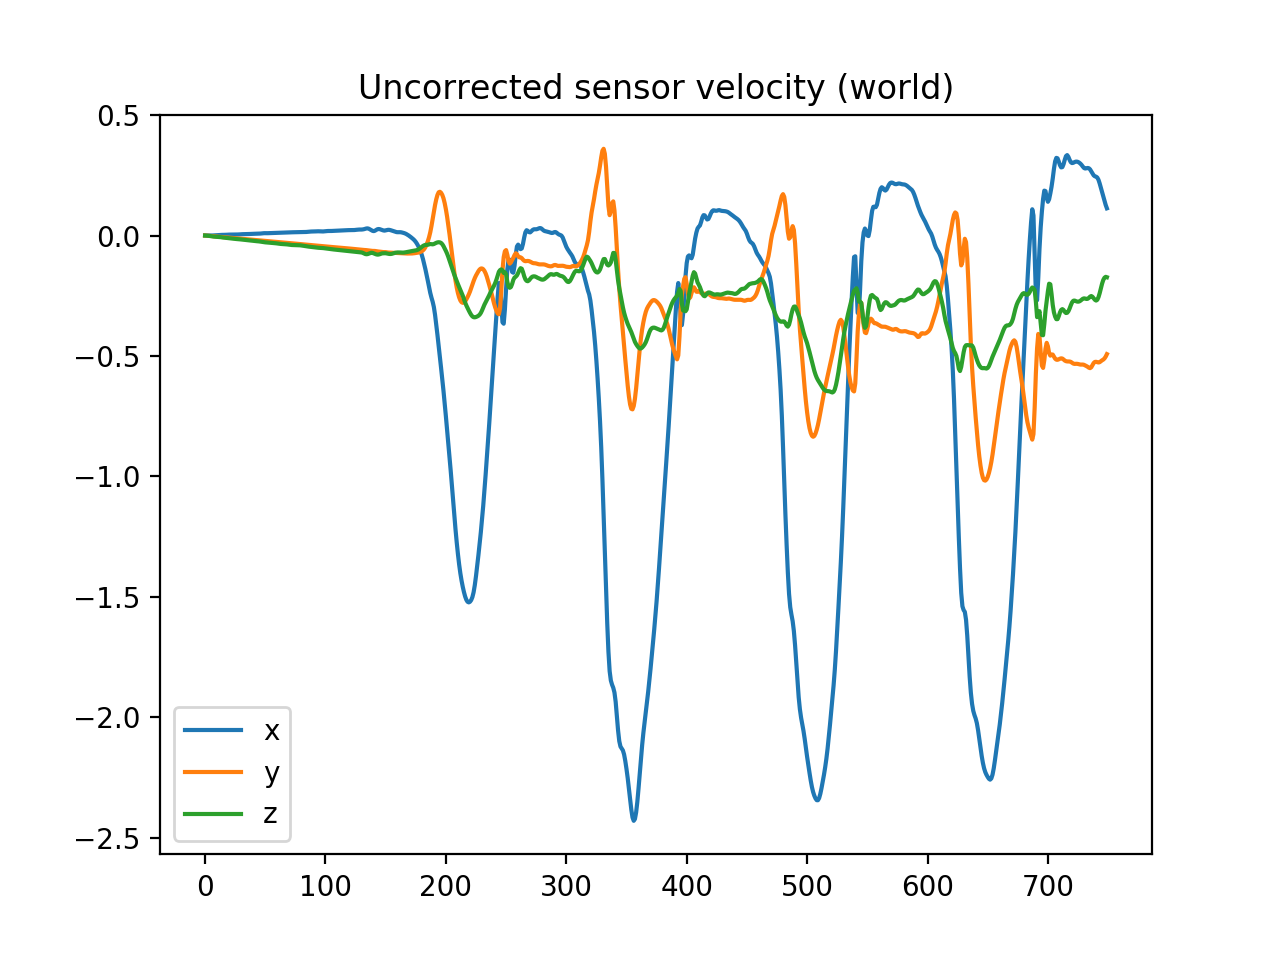

In [133]:
plt.figure()
plt.plot(world_vel_uncorrected)
plt.title('Uncorrected sensor velocity (world)')
plt.legend(['x','y','z'])
plt.show()

<IPython.core.display.Javascript object>


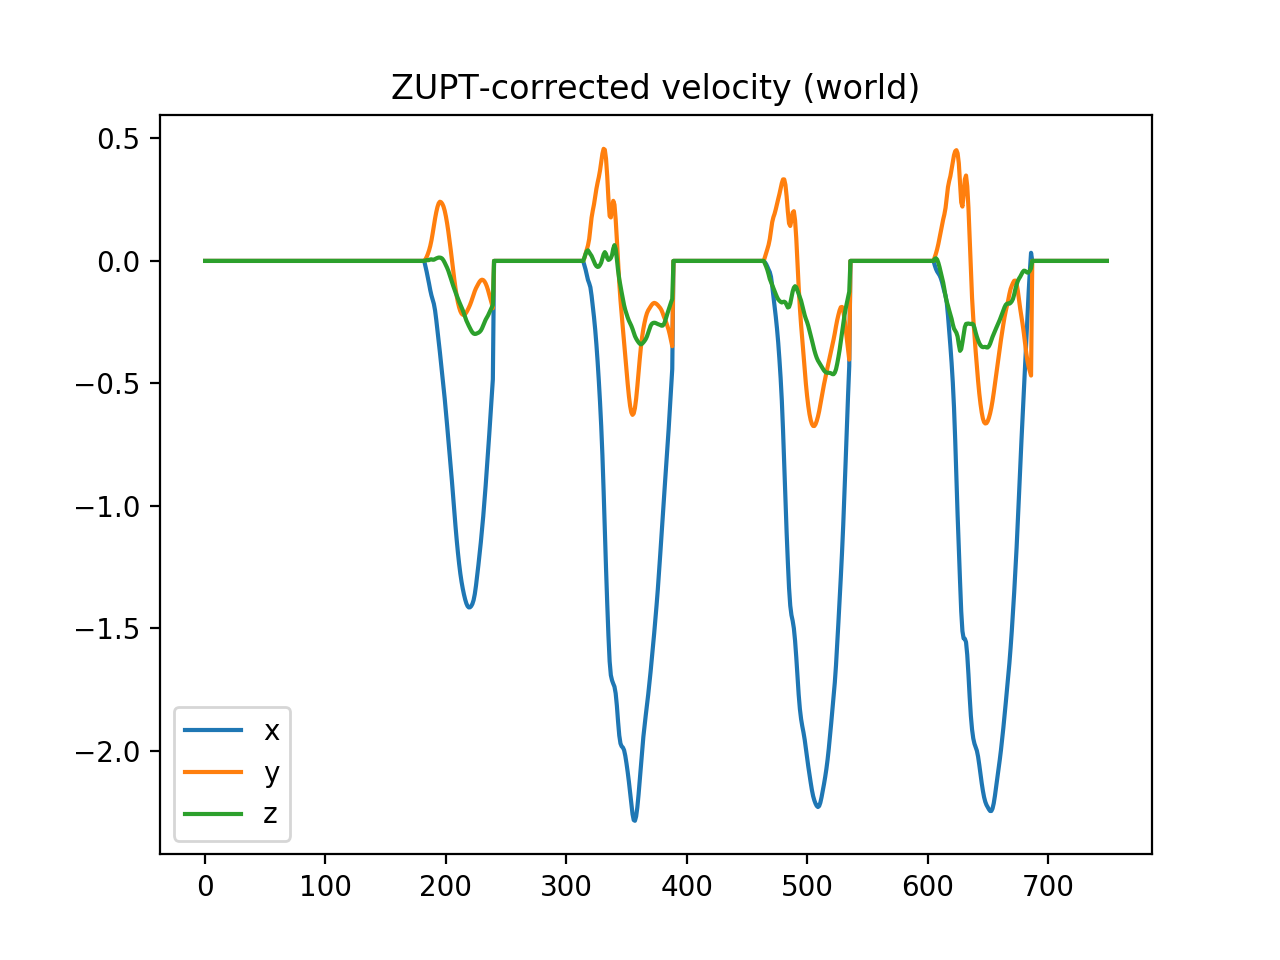

In [134]:
plt.figure()
plt.plot(world_vel)
plt.title('ZUPT-corrected velocity (world)')
plt.legend(['x','y','z'])
plt.show()

<IPython.core.display.Javascript object>


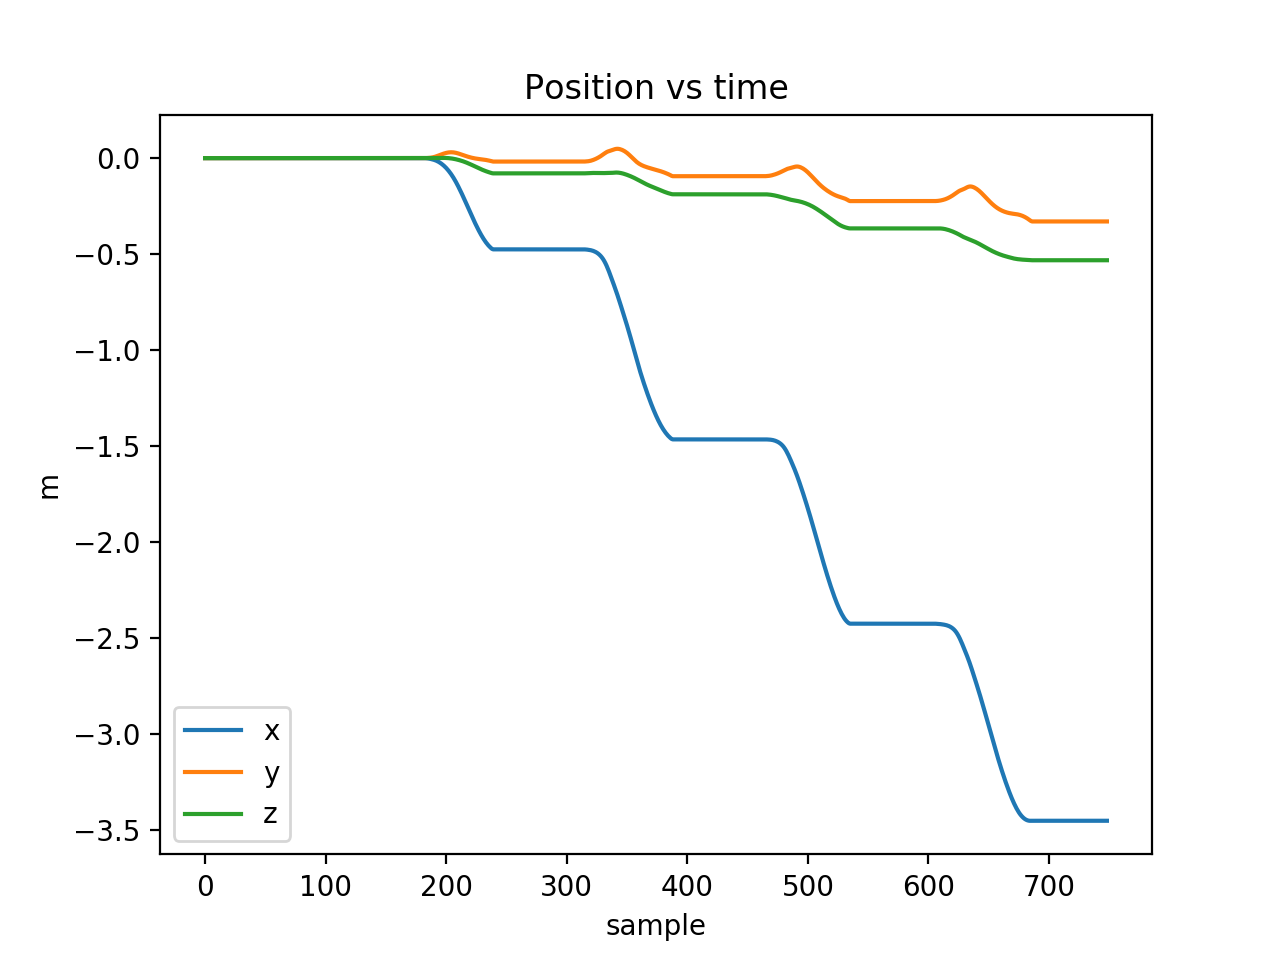

In [135]:
plt.figure()
plt.plot(global_pos)
plt.ylabel('m')
plt.xlabel('sample')
plt.title('Position vs time')
plt.legend(['x','y','z'])
plt.show()

<IPython.core.display.Javascript object>


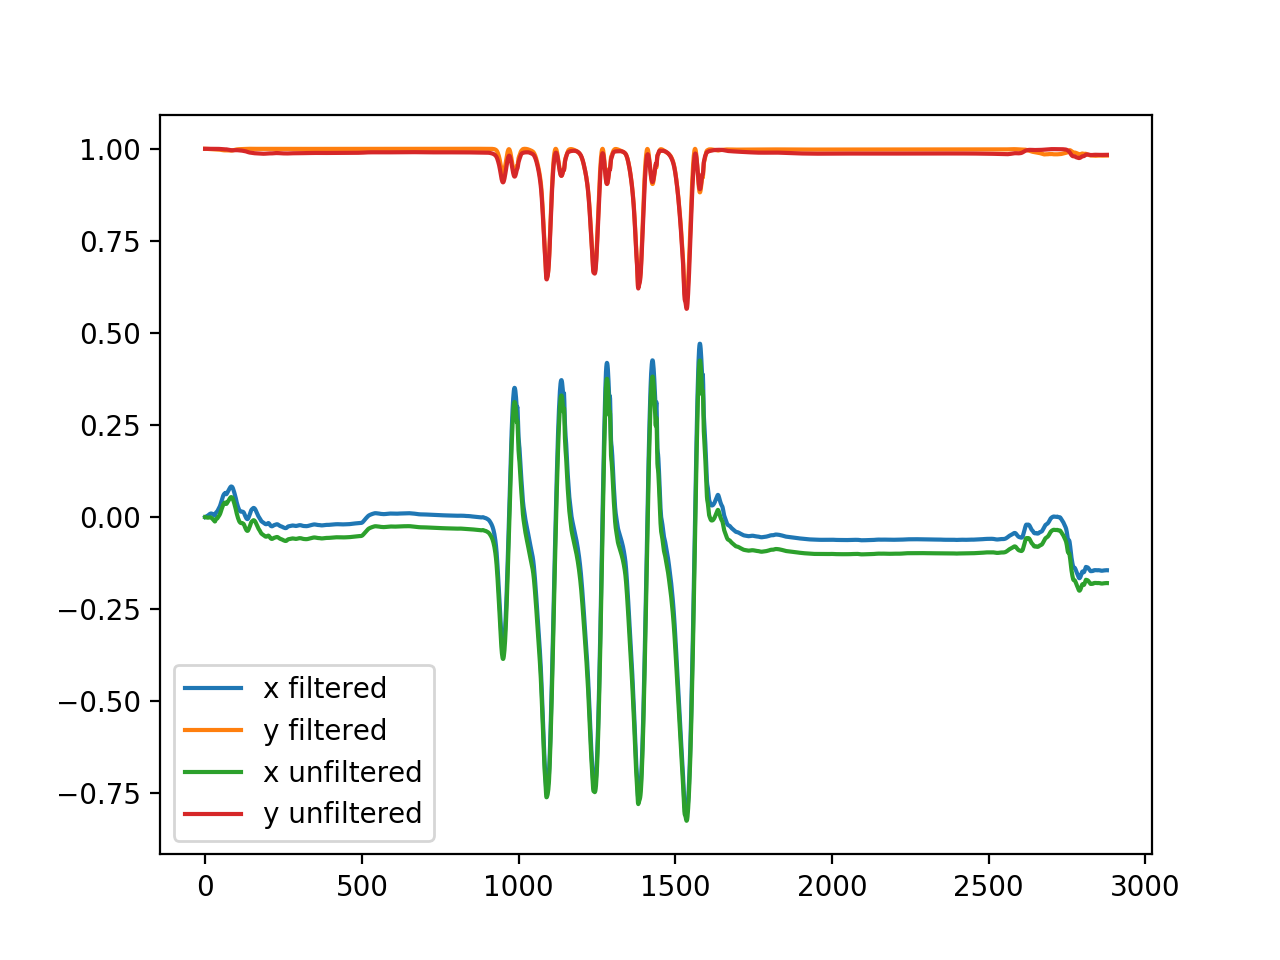

In [127]:
plot_direction_vector(quat_timeseries, quat_unfiltered)

In [128]:
# ### Plot y basis vector on the plane 
# v = np.quaternion(0,0,1,0)
# up_vectors = np.array([(q*v*q.conjugate()).vec for q in quat_timeseries])
# up_vectors_unfiltered = np.array([(q*v*q.conjugate()).vec for q in quat_unfiltered])

# plt.figure()
# plt.plot(up_vectors[:,0],up_vectors[:,1])
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.legend(['x','y'])
# plt.show()

<IPython.core.display.Javascript object>


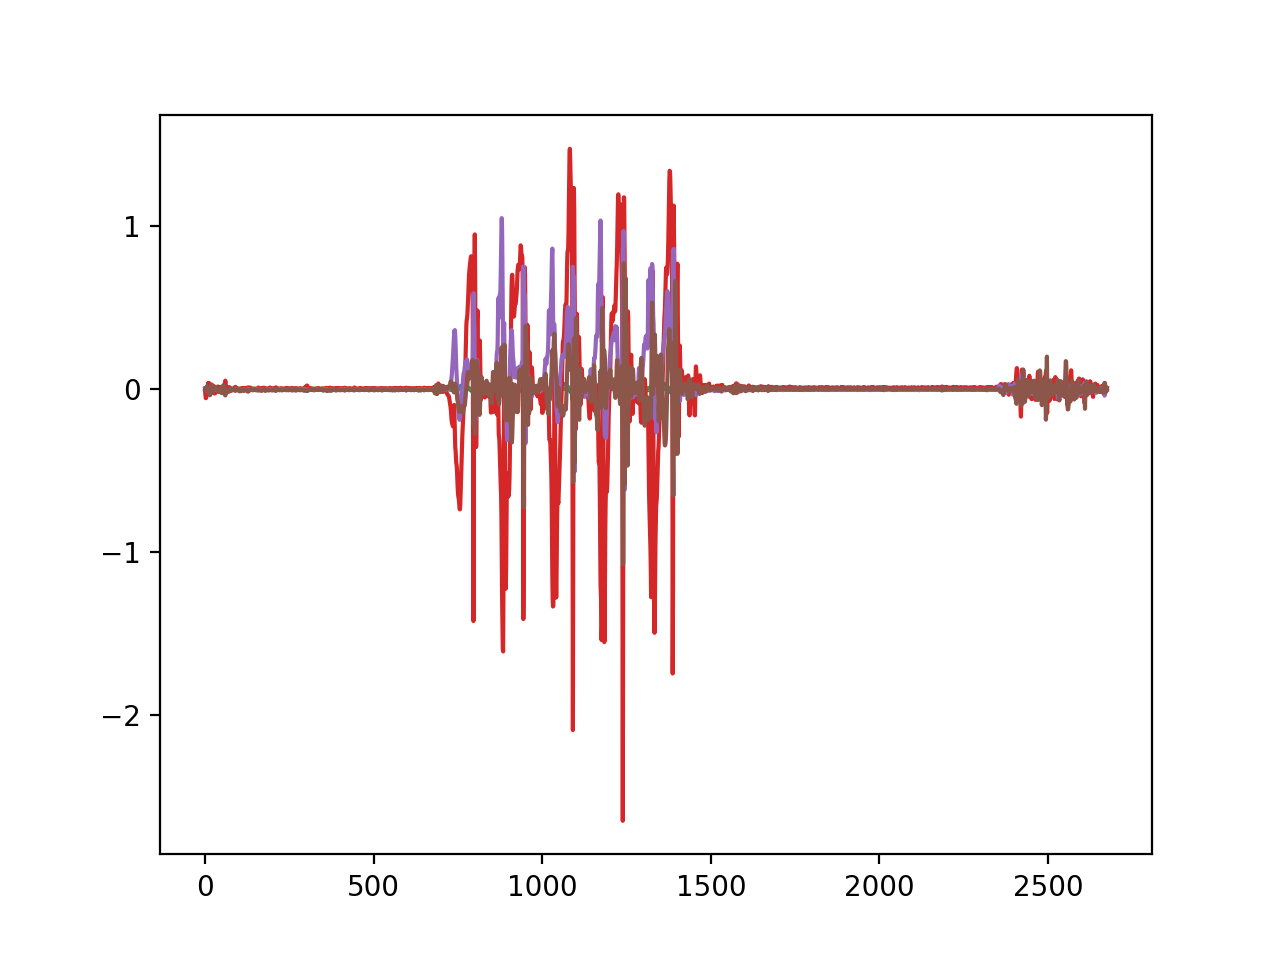

In [129]:
"""
Compare iPhone motion data to local acceleration compensated for gravity

Requires: quat_timeseries
"""

# Convert local accels to global accels
global_accels = v_local_vec_to_global(data_accel,quat_timeseries)
global_accels -= np.array([0,-1,0])

plt.figure()
plt.plot(global_accels[200:-1])
plt.plot(user_acc[200:-1])
plt.show()

### GRAVITY DATA FROM PS IS TOO FILTERED